### Run accuracy validation for given prompts on different models

In [2]:
from pathlib import Path
import sys
import json
import os

IN_GITHUB = os.getenv("GITHUB_ACTIONS") == "true"
try:
    import google.colab

    IN_COLAB = True
    print("Running as a Colab notebook")
except:
  IN_COLAB = False
  print("Not running as a Colab notebook")

if IN_COLAB:
  !pip install transformer_lens
  !pip install Levenshtein
  !pip install anthropic
  from google.colab import drive
  drive.mount('/content/drive')
  ! pwd # Returns /content
  ! cp "/content/drive/MyDrive/Colab Notebooks/temporal_scope_to_check_accuracy.json" /content/temporal_scope_to_check_accuracy.json
  ! cp "/content/drive/MyDrive/Colab Notebooks/.env.example" /content/.env.example
  from dotenv import load_dotenv
  load_dotenv(".env.example")

Running as a Colab notebook
Mounted at /content/drive
/content


1. Read the dataset, prepare inputs

In [3]:
temporal_dataset = None
dataset_path = "temporal_scope_to_check_accuracy.json"
with open(dataset_path) as f:
    temporal_dataset = json.load(f)

prompts = []
correct_answers = []
incorrect_answers = []

for sample in temporal_dataset:
    clean_question = sample["clean"]["question"]
    prompts.append(clean_question)
    correct_answers.append(sample["clean"]["answer"])
    incorrect_answers.append(sample["corrupted"]["answer"])

    corrupted_question = sample["corrupted"]["question"]
    prompts.append(corrupted_question)
    correct_answers.append(sample["corrupted"]["answer"])
    incorrect_answers.append(sample["clean"]["answer"])

In [4]:
models = ["Qwen/Qwen2.5-1.5B", "Qwen/Qwen2.5-3B", "Qwen/Qwen2.5-7B", "Qwen/Qwen3-0.6B", "Qwen/Qwen3-1.7B", "Qwen/Qwen3-4B", "Qwen/Qwen3-8B"]

In [21]:
# Expected results of validation:
# - Full model accuracy: can model accurately recognize that question implies short/long-time horizons?
# - Label prediction: can model correctly predict that next token after a prompt will be ' short' or ' long' horizon marker? (Also checks the model's conformance to a format)
# - Separtability of short/long term: how good does the model separate raw logits corresponding to the ' short' and ' long' markers for the questions? What about probabilities of these logits?
# - If dataset contains contrastive pairs, is there one circuit differentiating them or two? Are they really "contrastive" for LLMs?

In [5]:
# Additional AI-powered validation of the model's answer:
validation_prompt = """You are validating the correctness of LLM's answer to the following question.
Question: \"{question}\"
You need to study the generated text of the model to understand which time horizon the model has chosen as an answer to the question: short-term or long-term.
Please be aware that input prompt (or question) is prepended to the generated text of the model, so the model's output will contain it.
Model's output: \"{model_output}\"
After identification of model's answer to the question in the sense of short-term or long-term horizons, please compare its answer to the expected answer \"{expected_answer}\".
Do answers match?
"""
validation_response_format = {
  "format": {
      "type": "json_schema",
      "schema": {
          "type": "object",
          "properties": {
          "is_correct": {
              "type": "boolean",
              "description": "True if model answered correctly, False if not"
              }
          },
          "required": ["is_correct"],
          "additionalProperties": False
      }
  }
}

def ask_claude_for_correctness(question, model_output, expected_answer):
    try:
        client = anthropic.Anthropic()

        response = client.messages.create(
            model="claude-opus-4-6",
            max_tokens=1024,
            messages=[
                {
                    "role": "user",
                    "content": validation_prompt.format(question=question, model_output=model_output, expected_answer=expected_answer),
                }
            ],
            output_config=validation_response_format
        )
        json_object = json.loads(response.content[0].text)
        return json_object["is_correct"]
    except Exception as e:
        return f"Error quering the Claude-Opus-4.6: {str(e)}"

# Commented debug line:
# ask_claude_for_correctness("The goal is to make a cappuchino. It is a short-term or long-term goal? The answer is:",
#                            "The goal is to make a cappuchino. It is a short-term or long-term goal? The answer is:short-term goal",
#                           " short")

In [6]:
from transformer_lens import (
    HookedTransformer
)
import torch
import Levenshtein
import anthropic
import json
import numpy as np
import gc


first_tokens_accuracy_for_models = {}
classification_accuracy_for_models = {}
logits_diff_for_models = {}
probs_diff_for_models = {}


for model_name in models:
  gc.collect()
  # Create a model
  model = HookedTransformer.from_pretrained(model_name)

  # Tokenize prompts
  all_prompts_tokens = []
  for prompt in prompts:
    tokens = model.to_tokens(prompt)
    all_prompts_tokens.append(tokens)
  # Some verbose for visual validation of results
  for i in range(len(prompts)):
    string_tokens = [f"{i}, {model.to_string(t)}" for i, t in enumerate(all_prompts_tokens[i][0])]
    print(string_tokens)

  # Correct classifications to short or long horizons:
  correct_classifications = 0
  # Correct classifications of expected next token predictions:
  # It measures complex phenomena: correct guessing of time horizon and model's conformance to the asked format.
  correct_first_tokens = 0

  correct_answer_logits = []
  correct_answer_probs = []
  incorrect_answer_logits = []
  incorrect_answer_probs = []

  # Also variables for extra verbosing
  top3_tokens = []
  top3_logits = []
  for index, prompt_tokens in enumerate(all_prompts_tokens):
    logits, cache = model.run_with_cache(prompt_tokens)
    del cache
    gc.collect()

    # Only for verbosing purpose:
    sorted_logits = torch.sort(logits[-1, -1, :], descending=True)
    top3_tokens.append(sorted_logits.indices[0:3].cpu().detach())
    top3_logits.append(sorted_logits.values[0:3].cpu().detach().numpy())

    # Measuring short <-> long separability.
    # short <-> long distance calculation in raw logits and probabilities of
    # logits after applying the softmax
    correct_answer = correct_answers[index]
    incorrect_answer = incorrect_answers[index]

    correct_token = model.to_single_token(correct_answers[index])
    incorrect_token = model.to_single_token(incorrect_answers[index])

    correct_answer_logits.append(logits[-1, -1, correct_token].cpu().detach().numpy())
    incorrect_answer_logits.append(logits[-1, -1, incorrect_token].cpu().detach().numpy())

    log_probs = torch.nn.functional.softmax(logits[-1, -1, :], dim=-1)
    correct_answer_probs.append(log_probs[correct_token].cpu().detach().numpy())
    incorrect_answer_probs.append(log_probs[incorrect_token].cpu().detach().numpy())

    # Accuracy of labels prediction: accuracy of next-token prediction to be exactly the label we want.
    # Accuracy of complex phenomena: correct guessing of time horizon and model's conformance to the asked format.
    first_token = model.to_string(top3_tokens[index][0])
    correctness_ratio = Levenshtein.ratio(first_token, correct_answers[index])
    if correctness_ratio > 0.9:
      correct_first_tokens += 1
    print(f"\n\nFor prompt: {prompts[index]}:\n")
    print(f"First token: {first_token}, correct answer: {correct_answer}, similarity: {correctness_ratio}")

    # Accuracy of classification to short/long based on model's output context
    resulted_text = model.generate(prompt_tokens, max_new_tokens=20, do_sample=False, return_type='str', verbose=False)
    print(f"Resulted text: {resulted_text}")
    is_classification_correct = ask_claude_for_correctness(prompts[index], resulted_text, correct_answer)
    print(f"Classification is correct: {is_classification_correct}")
    correct_classifications += int(is_classification_correct)


    del logits
    del sorted_logits
    gc.collect()
  print(f"For model {model_name}: top-3 tokens = {model.to_string(torch.stack(top3_tokens))}")
  print(f"For model {model_name}: top-3 logits = {top3_logits}")
  print(f"For model {model_name}: correct first tokens = {correct_first_tokens}")
  print(f"For model {model_name}: correct classifications = {correct_classifications}")
  print(f"For model {model_name}: First token accuracy = {float(correct_first_tokens)/len(all_prompts_tokens)}")
  print(f"For model {model_name}: Classification accuracy = {float(correct_classifications)/len(all_prompts_tokens)}")
  print(f"For model {model_name}: correct answer logits = {correct_answer_logits}")
  print(f"For model {model_name}: incorrect answer logits = {incorrect_answer_logits}")
  print(f"For model {model_name}: correct answer probs = {correct_answer_probs}")
  print(f"For model {model_name}: incorrect answer probs = {incorrect_answer_probs}")

  first_tokens_accuracy_for_models[model_name] = float(correct_first_tokens)/len(all_prompts_tokens)
  classification_accuracy_for_models[model_name] = float(correct_classifications)/len(all_prompts_tokens)
  logits_diff_for_models[model_name] = np.abs(np.array(correct_answer_logits) - np.array(incorrect_answer_logits)).mean()
  probs_diff_for_models[model_name] = np.abs(np.array(correct_answer_probs) - np.array(incorrect_answer_probs)).mean()
  del top3_tokens

  print(f"First tokens accuracy for models: {first_tokens_accuracy_for_models}")
  print(f"Classification accuracy for models: {classification_accuracy_for_models}")
  print(f"Logits diff for models: {logits_diff_for_models}")
  print(f"Probs diff for models: {probs_diff_for_models}")
  del top3_logits
  del all_prompts_tokens
  del model

  gc.collect()


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Loaded pretrained model Qwen/Qwen2.5-1.5B into HookedTransformer
['0, The', '1,  goal', '2,  is', '3,  to', '4,  make', '5,  one', '6,  cup', '7,  of', '8,  coffee', '9, .', '10,  Is', '11,  this', '12,  a', '13,  short', '14, -term', '15,  or', '16,  long', '17, -term', '18,  goal', '19, ?', '20,  The', '21,  answer', '22,  is', '23, :']
['0, The', '1,  goal', '2,  is', '3,  to', '4,  master', '5,  the', '6,  craft', '7,  of', '8,  specialty', '9,  coffee', '10,  ro', '11, asting', '12, .', '13,  Is', '14,  this', '15,  a', '16,  short', '17, -term', '18,  or', '19,  long', '20, -term', '21,  goal', '22, ?', '23,  The', '24,  answer', '25,  is', '26, :']
['0, The', '1,  goal', '2,  is', '3,  to', '4,  take', '5,  a', '6,  ten', '7, -minute', '8,  walk', '9, .', '10,  Is', '11,  this', '12,  a', '13,  short', '14, -term', '15,  or', '16,  long', '17, -term', '18,  goal', '19, ?', '20,  The', '21,  answer', '22,  is', '23, :']
['0, The', '1,  goal', '2,  is', '3,  to', '4,  walk', '5,  

config.json:   0%|          | 0.00/683 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Loaded pretrained model Qwen/Qwen2.5-3B into HookedTransformer
['0, The', '1,  goal', '2,  is', '3,  to', '4,  make', '5,  one', '6,  cup', '7,  of', '8,  coffee', '9, .', '10,  Is', '11,  this', '12,  a', '13,  short', '14, -term', '15,  or', '16,  long', '17, -term', '18,  goal', '19, ?', '20,  The', '21,  answer', '22,  is', '23, :']
['0, The', '1,  goal', '2,  is', '3,  to', '4,  master', '5,  the', '6,  craft', '7,  of', '8,  specialty', '9,  coffee', '10,  ro', '11, asting', '12, .', '13,  Is', '14,  this', '15,  a', '16,  short', '17, -term', '18,  or', '19,  long', '20, -term', '21,  goal', '22, ?', '23,  The', '24,  answer', '25,  is', '26, :']
['0, The', '1,  goal', '2,  is', '3,  to', '4,  take', '5,  a', '6,  ten', '7, -minute', '8,  walk', '9, .', '10,  Is', '11,  this', '12,  a', '13,  short', '14, -term', '15,  or', '16,  long', '17, -term', '18,  goal', '19, ?', '20,  The', '21,  answer', '22,  is', '23, :']
['0, The', '1,  goal', '2,  is', '3,  to', '4,  walk', '5,  ac

config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Loaded pretrained model Qwen/Qwen2.5-7B into HookedTransformer
['0, The', '1,  goal', '2,  is', '3,  to', '4,  make', '5,  one', '6,  cup', '7,  of', '8,  coffee', '9, .', '10,  Is', '11,  this', '12,  a', '13,  short', '14, -term', '15,  or', '16,  long', '17, -term', '18,  goal', '19, ?', '20,  The', '21,  answer', '22,  is', '23, :']
['0, The', '1,  goal', '2,  is', '3,  to', '4,  master', '5,  the', '6,  craft', '7,  of', '8,  specialty', '9,  coffee', '10,  ro', '11, asting', '12, .', '13,  Is', '14,  this', '15,  a', '16,  short', '17, -term', '18,  or', '19,  long', '20, -term', '21,  goal', '22, ?', '23,  The', '24,  answer', '25,  is', '26, :']
['0, The', '1,  goal', '2,  is', '3,  to', '4,  take', '5,  a', '6,  ten', '7, -minute', '8,  walk', '9, .', '10,  Is', '11,  this', '12,  a', '13,  short', '14, -term', '15,  or', '16,  long', '17, -term', '18,  goal', '19, ?', '20,  The', '21,  answer', '22,  is', '23, :']
['0, The', '1,  goal', '2,  is', '3,  to', '4,  walk', '5,  ac

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Loaded pretrained model Qwen/Qwen3-0.6B into HookedTransformer
['0, The', '1,  goal', '2,  is', '3,  to', '4,  make', '5,  one', '6,  cup', '7,  of', '8,  coffee', '9, .', '10,  Is', '11,  this', '12,  a', '13,  short', '14, -term', '15,  or', '16,  long', '17, -term', '18,  goal', '19, ?', '20,  The', '21,  answer', '22,  is', '23, :']
['0, The', '1,  goal', '2,  is', '3,  to', '4,  master', '5,  the', '6,  craft', '7,  of', '8,  specialty', '9,  coffee', '10,  ro', '11, asting', '12, .', '13,  Is', '14,  this', '15,  a', '16,  short', '17, -term', '18,  or', '19,  long', '20, -term', '21,  goal', '22, ?', '23,  The', '24,  answer', '25,  is', '26, :']
['0, The', '1,  goal', '2,  is', '3,  to', '4,  take', '5,  a', '6,  ten', '7, -minute', '8,  walk', '9, .', '10,  Is', '11,  this', '12,  a', '13,  short', '14, -term', '15,  or', '16,  long', '17, -term', '18,  goal', '19, ?', '20,  The', '21,  answer', '22,  is', '23, :']
['0, The', '1,  goal', '2,  is', '3,  to', '4,  walk', '5,  ac

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/622M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Loaded pretrained model Qwen/Qwen3-1.7B into HookedTransformer
['0, The', '1,  goal', '2,  is', '3,  to', '4,  make', '5,  one', '6,  cup', '7,  of', '8,  coffee', '9, .', '10,  Is', '11,  this', '12,  a', '13,  short', '14, -term', '15,  or', '16,  long', '17, -term', '18,  goal', '19, ?', '20,  The', '21,  answer', '22,  is', '23, :']
['0, The', '1,  goal', '2,  is', '3,  to', '4,  master', '5,  the', '6,  craft', '7,  of', '8,  specialty', '9,  coffee', '10,  ro', '11, asting', '12, .', '13,  Is', '14,  this', '15,  a', '16,  short', '17, -term', '18,  or', '19,  long', '20, -term', '21,  goal', '22, ?', '23,  The', '24,  answer', '25,  is', '26, :']
['0, The', '1,  goal', '2,  is', '3,  to', '4,  take', '5,  a', '6,  ten', '7, -minute', '8,  walk', '9, .', '10,  Is', '11,  this', '12,  a', '13,  short', '14, -term', '15,  or', '16,  long', '17, -term', '18,  goal', '19, ?', '20,  The', '21,  answer', '22,  is', '23, :']
['0, The', '1,  goal', '2,  is', '3,  to', '4,  walk', '5,  ac

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Loaded pretrained model Qwen/Qwen3-4B into HookedTransformer
['0, The', '1,  goal', '2,  is', '3,  to', '4,  make', '5,  one', '6,  cup', '7,  of', '8,  coffee', '9, .', '10,  Is', '11,  this', '12,  a', '13,  short', '14, -term', '15,  or', '16,  long', '17, -term', '18,  goal', '19, ?', '20,  The', '21,  answer', '22,  is', '23, :']
['0, The', '1,  goal', '2,  is', '3,  to', '4,  master', '5,  the', '6,  craft', '7,  of', '8,  specialty', '9,  coffee', '10,  ro', '11, asting', '12, .', '13,  Is', '14,  this', '15,  a', '16,  short', '17, -term', '18,  or', '19,  long', '20, -term', '21,  goal', '22, ?', '23,  The', '24,  answer', '25,  is', '26, :']
['0, The', '1,  goal', '2,  is', '3,  to', '4,  take', '5,  a', '6,  ten', '7, -minute', '8,  walk', '9, .', '10,  Is', '11,  this', '12,  a', '13,  short', '14, -term', '15,  or', '16,  long', '17, -term', '18,  goal', '19, ?', '20,  The', '21,  answer', '22,  is', '23, :']
['0, The', '1,  goal', '2,  is', '3,  to', '4,  walk', '5,  acro

config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.19G [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Loaded pretrained model Qwen/Qwen3-8B into HookedTransformer
['0, The', '1,  goal', '2,  is', '3,  to', '4,  make', '5,  one', '6,  cup', '7,  of', '8,  coffee', '9, .', '10,  Is', '11,  this', '12,  a', '13,  short', '14, -term', '15,  or', '16,  long', '17, -term', '18,  goal', '19, ?', '20,  The', '21,  answer', '22,  is', '23, :']
['0, The', '1,  goal', '2,  is', '3,  to', '4,  master', '5,  the', '6,  craft', '7,  of', '8,  specialty', '9,  coffee', '10,  ro', '11, asting', '12, .', '13,  Is', '14,  this', '15,  a', '16,  short', '17, -term', '18,  or', '19,  long', '20, -term', '21,  goal', '22, ?', '23,  The', '24,  answer', '25,  is', '26, :']
['0, The', '1,  goal', '2,  is', '3,  to', '4,  take', '5,  a', '6,  ten', '7, -minute', '8,  walk', '9, .', '10,  Is', '11,  this', '12,  a', '13,  short', '14, -term', '15,  or', '16,  long', '17, -term', '18,  goal', '19, ?', '20,  The', '21,  answer', '22,  is', '23, :']
['0, The', '1,  goal', '2,  is', '3,  to', '4,  walk', '5,  acro

,Qwen2 first tokens accuracy
Qwen/Qwen2.5-1.5B,0.740506
Qwen/Qwen2.5-3B,0.955696
Qwen/Qwen2.5-7B,0.772152


,Qwen3 first tokens accuracy
Qwen/Qwen3-0.6B,0.449367
Qwen/Qwen3-1.7B,0.784810
Qwen/Qwen3-4B,0.848101
Qwen/Qwen3-8B,0.905063


<Axes: title={'center': 'Qwen3 First token accuracy'}>

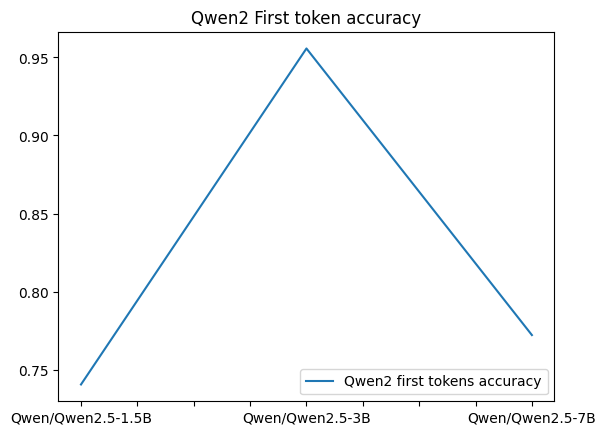

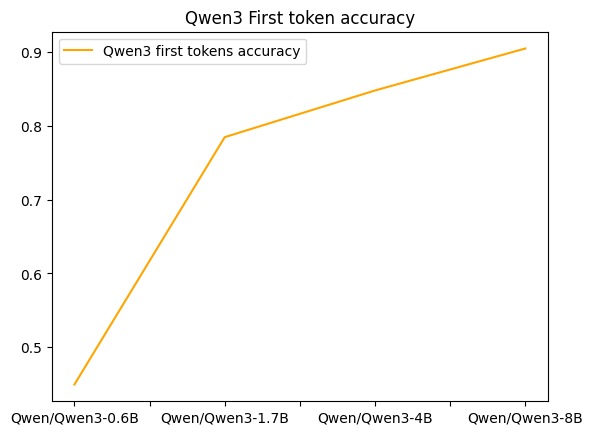

In [18]:
import pandas as pd

qwen2_ft_acc = {key : value for key, value in first_tokens_accuracy_for_models.items() if "Qwen2" in key}
qwen3_ft_acc = {key : value for key, value in first_tokens_accuracy_for_models.items() if "Qwen3" in key}
qwen2_ft_acc_df = pd.DataFrame(qwen2_ft_acc.values(), qwen2_ft_acc.keys(), columns=["Qwen2 first tokens accuracy"])
qwen3_ft_acc_df = pd.DataFrame(qwen3_ft_acc.values(), qwen3_ft_acc.keys(), columns=["Qwen3 first tokens accuracy"])
display(qwen2_ft_acc_df)
display(qwen3_ft_acc_df)
qwen2_ft_acc_df.plot(title="Qwen2 First token accuracy")
qwen3_ft_acc_df.plot(title="Qwen3 First token accuracy", color="orange")

,Qwen2 accuracy
Qwen/Qwen2.5-1.5B,0.753165
Qwen/Qwen2.5-3B,0.974684
Qwen/Qwen2.5-7B,0.905063


,Qwen3 accuracy
Qwen/Qwen3-0.6B,0.835443
Qwen/Qwen3-1.7B,0.784810
Qwen/Qwen3-4B,0.981013
Qwen/Qwen3-8B,0.905063


<Axes: title={'center': 'Qwen3 accuracy of recognizing long or short horizon'}>

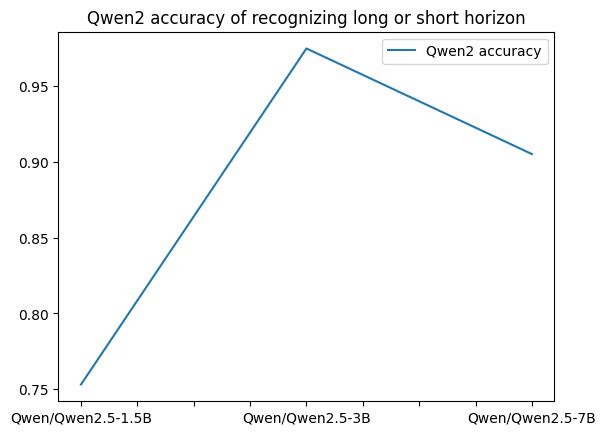

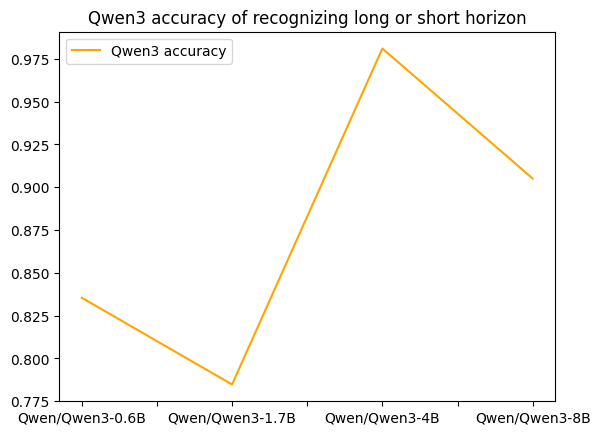

In [19]:
qwen2_acc = {key : value for key, value in classification_accuracy_for_models.items() if "Qwen2" in key}
qwen3_acc = {key : value for key, value in classification_accuracy_for_models.items() if "Qwen3" in key}
qwen2_acc_df = pd.DataFrame(qwen2_acc.values(), qwen2_acc.keys(), columns=["Qwen2 accuracy"])
qwen3_acc_df = pd.DataFrame(qwen3_acc.values(), qwen3_acc.keys(), columns=["Qwen3 accuracy"])
display(qwen2_acc_df)
display(qwen3_acc_df)
qwen2_acc_df.plot(title="Qwen2 accuracy of recognizing long or short horizon")
qwen3_acc_df.plot(title="Qwen3 accuracy of recognizing long or short horizon", color="orange")

,Qwen2 logit difference
Qwen/Qwen2.5-1.5B,0.918133
Qwen/Qwen2.5-3B,1.520548
Qwen/Qwen2.5-7B,1.803325


,Qwen3 logit difference
Qwen/Qwen3-0.6B,2.592209
Qwen/Qwen3-1.7B,1.101370
Qwen/Qwen3-4B,4.552690
Qwen/Qwen3-8B,4.261618


<Axes: title={'center': 'Qwen3 logit differences between " short" and " long" tokens in answers'}>

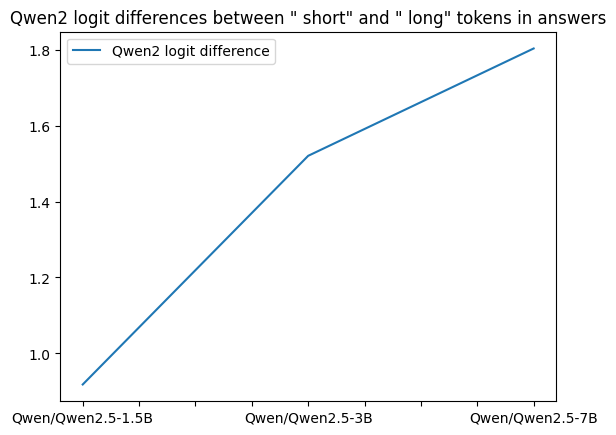

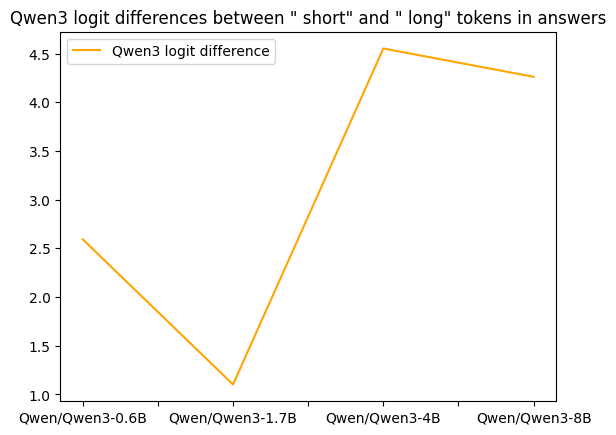

In [20]:
qwen2_log_diff = {key : value for key, value in logits_diff_for_models.items() if "Qwen2" in key}
qwen3_log_diff = {key : value for key, value in logits_diff_for_models.items() if "Qwen3" in key}
qwen2_log_diff_df = pd.DataFrame(qwen2_log_diff.values(), qwen2_log_diff.keys(), columns=["Qwen2 logit difference"])
qwen3_log_diff_df = pd.DataFrame(qwen3_log_diff.values(), qwen3_log_diff.keys(), columns=["Qwen3 logit difference"])
display(qwen2_log_diff_df)
display(qwen3_log_diff_df)
qwen2_log_diff_df.plot(title="Qwen2 logit differences between \" short\" and \" long\" tokens in answers")
qwen3_log_diff_df.plot(title="Qwen3 logit differences between \" short\" and \" long\" tokens in answers", color="orange")

,Qwen2 logits probabilities difference
Qwen/Qwen2.5-1.5B,0.210650
Qwen/Qwen2.5-3B,0.277383
Qwen/Qwen2.5-7B,0.161434


,Qwen3 logits probabilities difference
Qwen/Qwen3-0.6B,0.198621
Qwen/Qwen3-1.7B,0.311043
Qwen/Qwen3-4B,0.549141
Qwen/Qwen3-8B,0.481373


<Axes: title={'center': 'Qwen3 logits probabilities differences between " short" and " long" tokens in answers'}>

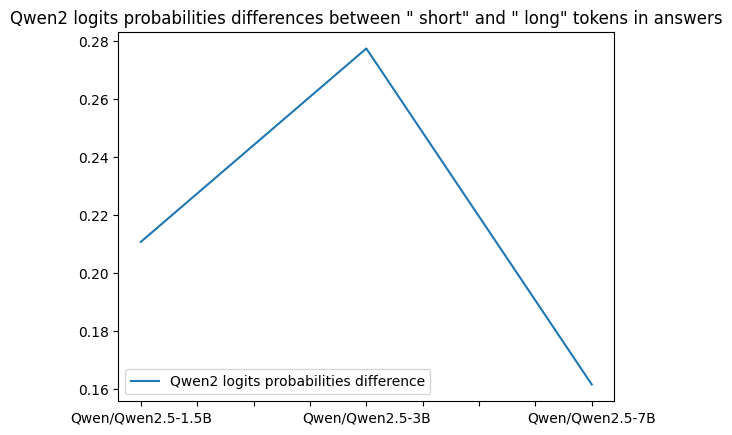

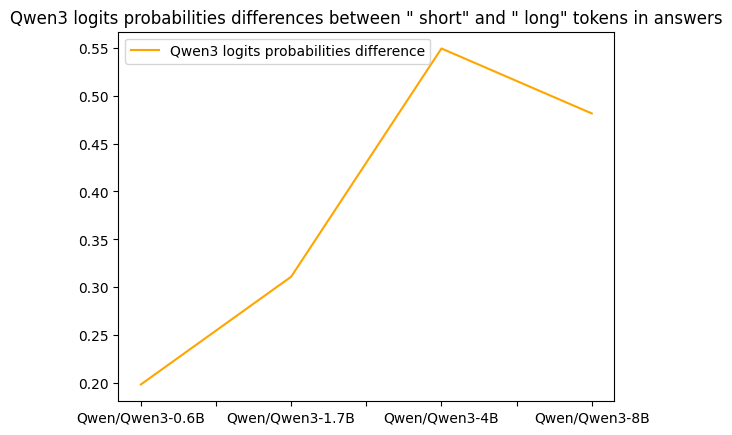

In [22]:
qwen2_logits_probability_diff = {key : value for key, value in probs_diff_for_models.items() if "Qwen2" in key}
qwen3_logits_probability_diff = {key : value for key, value in probs_diff_for_models.items() if "Qwen3" in key}
qwen2_logits_probability_diff_df = pd.DataFrame(qwen2_logits_probability_diff.values(), qwen2_logits_probability_diff.keys(), columns=["Qwen2 logits probabilities difference"])
qwen3_logits_probability_diff_df = pd.DataFrame(qwen3_logits_probability_diff.values(), qwen3_logits_probability_diff.keys(), columns=["Qwen3 logits probabilities difference"])
display(qwen2_logits_probability_diff_df)
display(qwen3_logits_probability_diff_df)
qwen2_logits_probability_diff_df.plot(title="Qwen2 logits probabilities differences between \" short\" and \" long\" tokens in answers")
qwen3_logits_probability_diff_df.plot(title="Qwen3 logits probabilities differences between \" short\" and \" long\" tokens in answers", color="orange")

Does the antagonisms of concepts increase with the model size?